### Task Description 

The objective is to predict engine failure using its performance indicators 

Given data represents performance indicators of engines for each cycle.
<br>
Each engine has its own id, each cycle numerated from 1 to the last cycle before its failure.

### Data Preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

In [3]:
df = pd.read_csv(r'C:\Users\artyo\OneDrive\Рабочий стол\Datasets\data.csv')

In [4]:
# data dimension
print('Data dimension:',df.shape)

Data dimension: (16138, 25)


In [5]:
# data sample
df.head(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
5,1,6,518.67,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100,642.10,38.98,23.3669,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,-0.0043,-0.0001
6,1,7,518.67,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100,642.48,39.10,23.3774,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,0.0010,0.0001
7,1,8,518.67,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100,642.56,38.97,23.3106,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,-0.0034,0.0003
8,1,9,518.67,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100,642.12,39.05,23.4066,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,0.0008,0.0001
9,1,10,518.67,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100,641.71,38.95,23.4694,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,-0.0033,0.0001


In [6]:
# Number of engines 
print('Number of engines:',df['id'].unique().shape[0])

Number of engines: 80


In [7]:
# Adding max cycle number for each engine 
df = pd.merge(df, df.groupby('id')['cycle'].max().rename('engine_max_cycle'), 
              on = 'id', 
              how = 'left')


# Number of cycles before failure
df['cycles_before_failure'] = df['engine_max_cycle'] - df['cycle']


# Last cycle flag construction 
df['last_cycle_flg'] = df['cycles_before_failure'].apply(lambda x: 1 if x == 0 else 0)

In [8]:
# Checking for redundant features
redundant_features = []

for f in df.columns:
    if len(df[f].value_counts()) == 1:
        redundant_features.append(f)
        
print('Constant feautes:', redundant_features)


# Dropping
df.drop(columns = redundant_features,
        inplace = True)

Constant feautes: ['p00', 'p01', 'p07', 'p09', 'p10', 'p16']


In [9]:
# Checking for redundant features
duplicateColumnNames = set()
 
# Searching for duplicated features
for x in range(df.shape[1]):
    col = df.iloc[:, x]
    for y in range(x + 1, df.shape[1]):
        otherCol = df.iloc[:, y]
        if col.equals(otherCol):
            duplicateColumnNames.add(df.columns.values[y])
print('Duplicated features:', duplicateColumnNames)

Duplicated features: set()


In [10]:
# Checking for missing values
print('Number of missing values:', df.isnull().sum().sum())

Number of missing values: 0


#### The engine failure classification algorithm described as follows:
1. Build regression model predicting 'wear indicator': how close is engine to its last cycle before failure
2. Setting 'risk threshold': if wear less than threshold, engine considered as safe, engine is at risk of failure 
3. Setting 'failure threshold': if wear more than threshold, engine considered as failured, else not failured.
4. Classification based on risky and failure engine conditions

In [11]:
# Constructing "wear" indicator with min value of zero and max value of 100

df['wear'] = df['cycle']/df['engine_max_cycle']*100

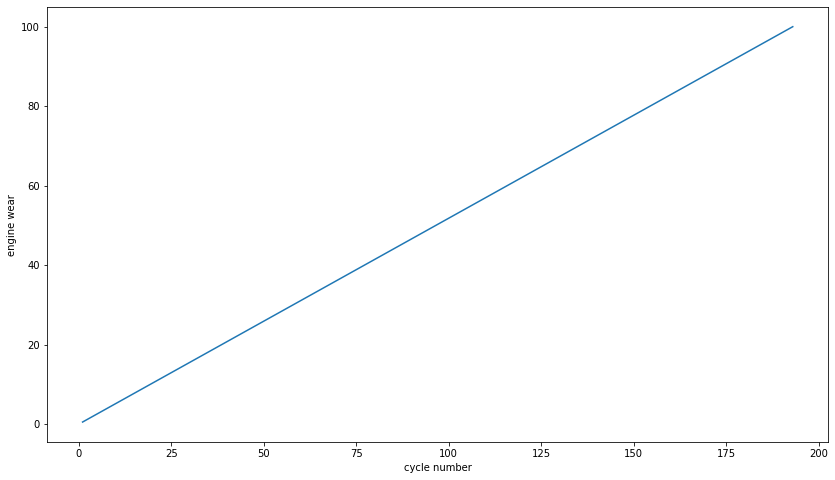

In [12]:
# Engine wear example 
# increasing with cycle number growing

plt.figure(figsize=(14,8))

plt.plot(df[df['id'] == 55]['cycle'].values,
         df[df['id'] == 55]['wear'].values)

plt.xlabel('cycle number')
plt.ylabel('engine wear')       
plt.show()

In [13]:
# Setting alert flag to the engines with wear indicator more than 90  threshold

df['alert_flg'] = df['wear'].apply(lambda x: 1 if x >= 90 else 0)

In [14]:
# excluding inappropriate features for training such as engine id or constructed target features 

feature_list = [feature for feature in df.columns \
                if feature not in ['id','engine_max_cycle', 'cycles_before_failure', 'last_cycle_flg', 'wear', 'alert_flg']]

In [15]:
# Feature correlation with 'Wear'
df[feature_list + ['wear']].corr()['wear'].sort_values()

p03     -0.693559
p18     -0.677511
p13     -0.664754
p12     -0.658006
s1      -0.001863
s2       0.008249
p17      0.121516
p05      0.369310
p20      0.450462
p19      0.559404
p04      0.561427
p14      0.611629
p11      0.629858
p08      0.635208
p06      0.667561
p15      0.705459
p02      0.721564
cycle    0.919586
wear     1.000000
Name: wear, dtype: float64

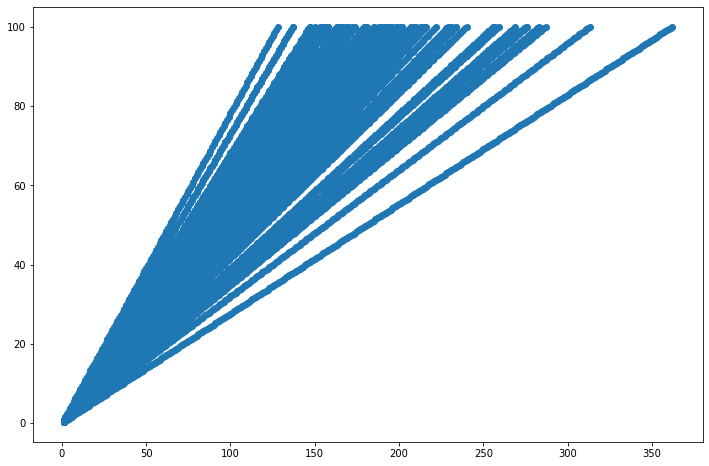

In [16]:
# Scatterplot example
# Positively correlated lines for each engine 
plt.scatter(df['cycle'],
            df['wear'])

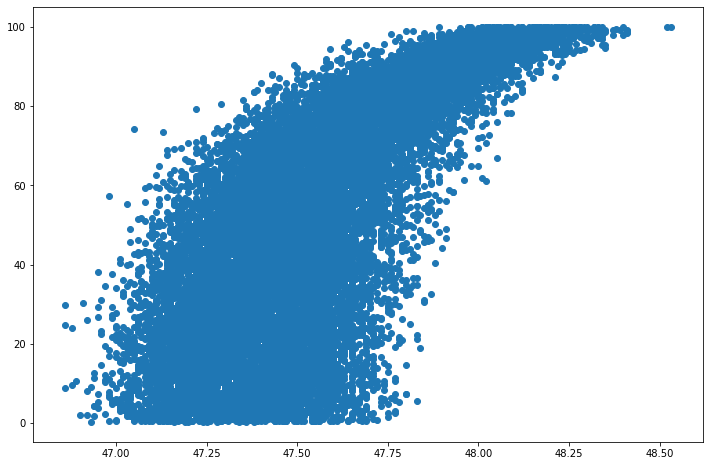

In [17]:
# Scatterplot example
plt.scatter(df['p02'],
            df['wear'])

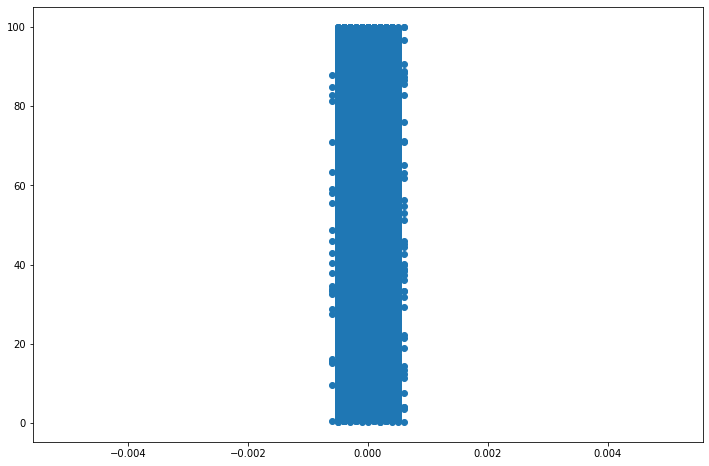

In [18]:
# Scatterplot example
# No correlation with 'Wear'
plt.scatter(df['s2'],
            df['wear'])

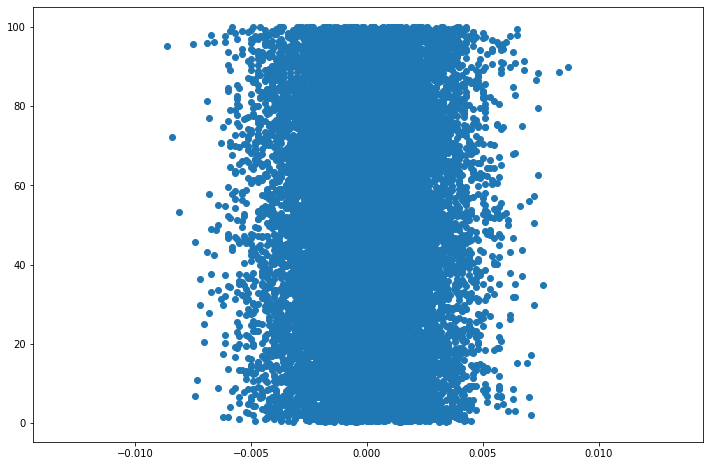

In [19]:
# Scatterplot example
# No correlation with 'Wear'
plt.scatter(df['s1'],
            df['wear'])

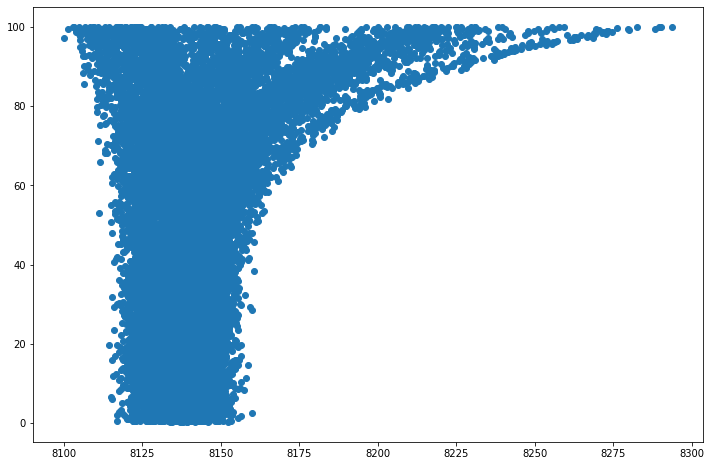

In [20]:
# Scatterplot example
# Almost No correlation with 'Wear'
plt.scatter(df['p05'],
            df['wear'])

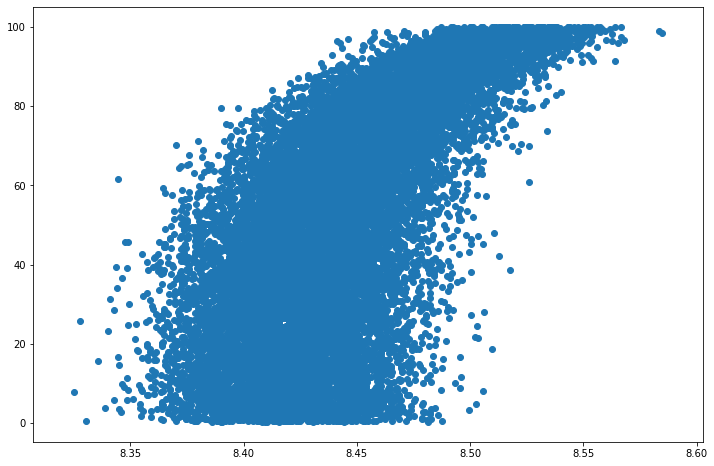

In [21]:
plt.scatter(df['p06'],
            df['wear'])

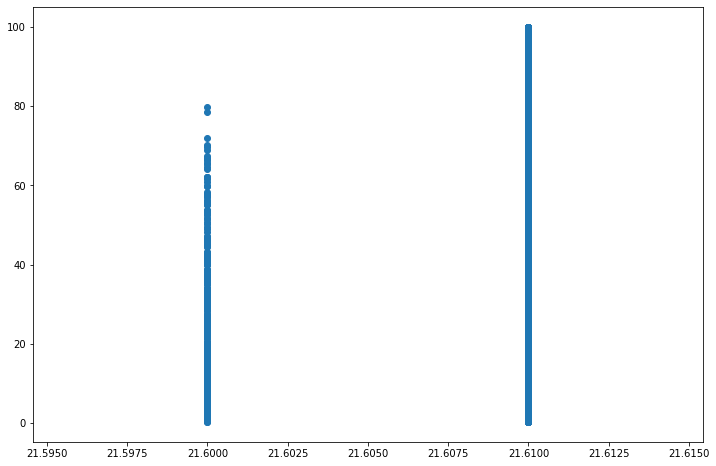

In [22]:
# Scatterplot example
# No correlation with 'Wear'
plt.scatter(df['p17'],
            df['wear'])

In [23]:
# Excluding non-correlating features
feature_list = [e for e in feature_list if e not in ['s1', 's2', 'p17', 'p05', 'p20', 'alert_flg']]

In [24]:
# Splitting engines for training/dev/test
# Training: 60%
# Dev: 20%
# Test: 20%

# unique engine labels 
engines = df.id.unique()

# randomly choosing lables for training 
train_engines = np.random.choice(engines,
                                 size = int(len(engines) * 0.6),
                                 replace = False)

# setting remaining engines for dev and test sets  
dev_and_test_engines = np.setdiff1d(engines, train_engines)

dev_engines = np.random.choice(np.setdiff1d(engines,train_engines),
                               size = int(len(dev_and_test_engines) * 0.5),
                               replace = False)

test_engines = np.setdiff1d(dev_and_test_engines, dev_engines)

                                

In [25]:
# Splitting train and test data 
train_df, dev_df = df[df['id'].isin(train_engines)], df[df['id'].isin(dev_engines)]

# Splitting dependent and independent features
# Dependent feature is wear 
X_train, Y_train = train_df[feature_list], train_df['wear']
X_dev, Y_dev = dev_df[feature_list], dev_df['wear']

In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [27]:
# fitting XGB regressor 
regressor = XGBRegressor()
regressor.fit(X_train, Y_train)

# Setting predicted wear to dev set for the following classification 
dev_df['wear_prediction'] = regressor.predict(X_dev)

[01:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
train_rmse = np.sqrt(mean_squared_error(regressor.predict(X_train), Y_train))
dev_rmse = np.sqrt(mean_squared_error(regressor.predict(X_dev), Y_dev))

In [29]:
print('Train RMSE:', train_rmse)
print('Dev RMSE:', dev_rmse)

Train RMSE: 5.735048934930522
Dev RMSE: 6.165332509315007


In [30]:
# Choosing dev engine for plotting predicted wear example
plot_engines = np.random.choice(dev_engines, 3, 
                                replace = False)

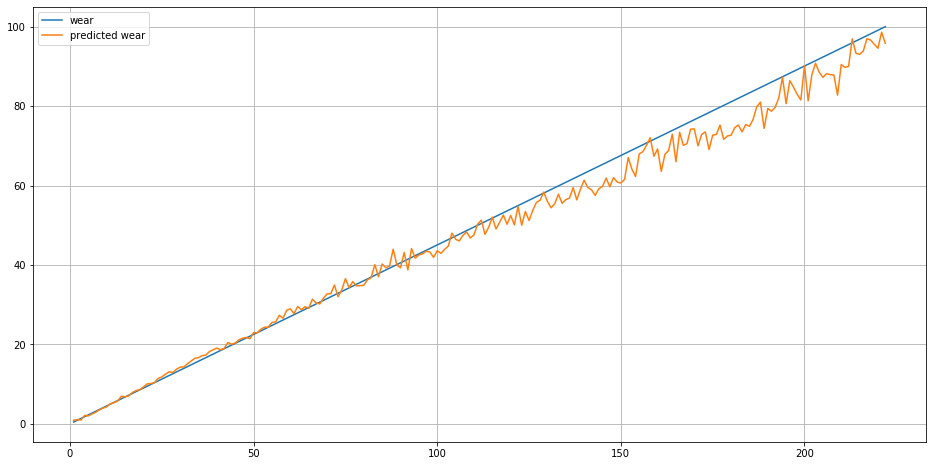

In [31]:
# Predicted wear example №1

plt.figure(figsize=(16,8))

plt.plot(dev_df[dev_df['id'] == plot_engines[0]]['cycle'].values,
         dev_df[dev_df['id'] == plot_engines[0]]['wear'].values,
         label = 'wear')
         
plt.plot(dev_df[dev_df['id'] == plot_engines[0]]['cycle'].values,
         dev_df[dev_df['id'] == plot_engines[0]]['wear_prediction'].values,
         label = 'predicted wear')
      
plt.legend()
plt.grid()
plt.show()

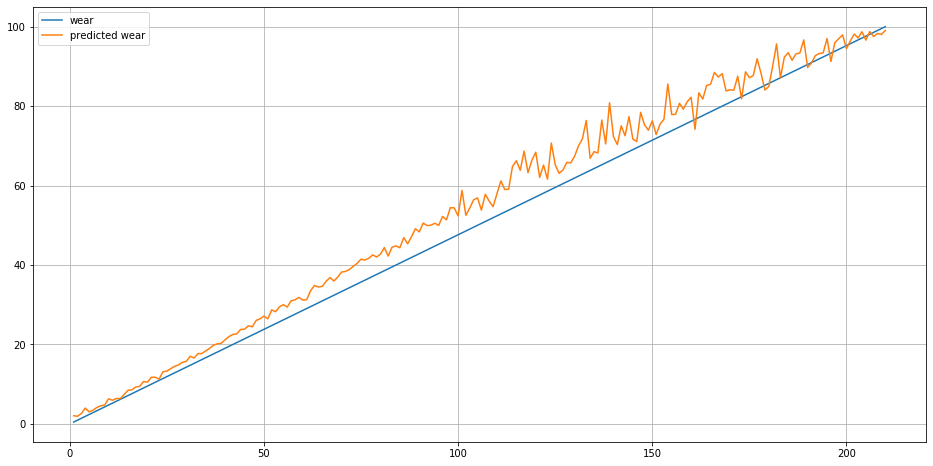

In [32]:
# Predicted wear example №2

plt.figure(figsize=(16,8))

plt.plot(dev_df[dev_df['id'] == plot_engines[1]]['cycle'].values,
         dev_df[dev_df['id'] == plot_engines[1]]['wear'].values,
         label = 'wear')
         
plt.plot(dev_df[dev_df['id'] == plot_engines[1]]['cycle'].values,
         dev_df[dev_df['id'] == plot_engines[1]]['wear_prediction'].values,
         label = 'predicted wear')
      
plt.legend()
plt.grid()
plt.show()

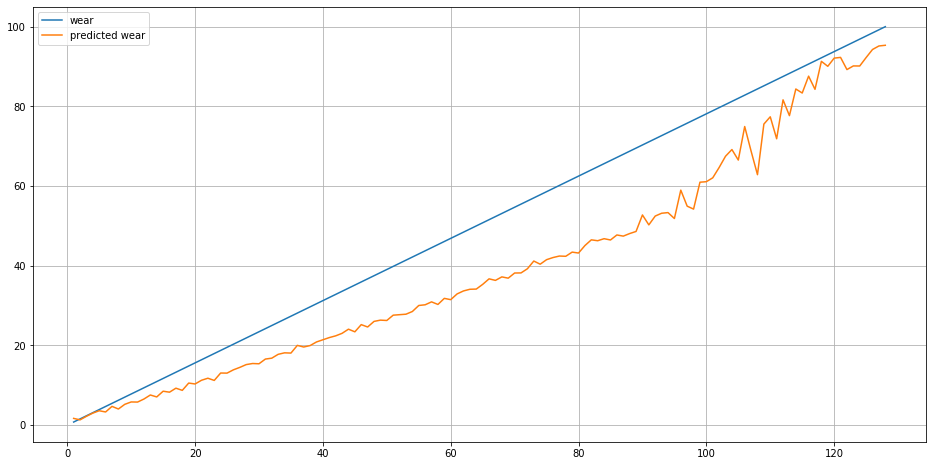

In [33]:
# Predicted wear example №3

plt.figure(figsize=(16,8))

plt.plot(dev_df[dev_df['id'] == plot_engines[2]]['cycle'].values,
         dev_df[dev_df['id'] == plot_engines[2]]['wear'].values,
         label = 'wear')
         
plt.plot(dev_df[dev_df['id'] == plot_engines[2]]['cycle'].values,
         dev_df[dev_df['id'] == plot_engines[2]]['wear_prediction'].values,
         label = 'predicted wear')
      
plt.legend()
plt.grid()
plt.show()

For further failure classification chosen rows with wear indicator more than 75 only as a risky condition.
<br>
If wear indicator less than 75, it's  failure flag set as 0.


In [34]:
# Choosing engines with failure risk from training set 
train_df, test_df = train_df[train_df['wear'] >= 80], dev_df[dev_df['wear'] >= 80]

# Splitting dependent and independent features 
# Predicted wear is usend for dev set
# Actual wear is used for training

X_train, Y_train = train_df[feature_list + ['wear']], train_df['alert_flg']
X_dev, Y_dev = dev_df[feature_list + ['wear_prediction']], dev_df['alert_flg']

In [35]:
Y_dev.value_counts()

0    2686
1     308
Name: alert_flg, dtype: int64

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [37]:
# Fitting random forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
# Result metrics

train_accuracy = accuracy_score(clf.predict(X_train), Y_train)
dev_accuracy = accuracy_score(clf.predict(X_dev), Y_dev)

train_recall = recall_score(clf.predict(X_train), Y_train)
dev_recall = recall_score(clf.predict(X_dev), Y_dev)

train_precision = precision_score(clf.predict(X_train), Y_train)
dev_precision = precision_score(clf.predict(X_dev), Y_dev)

In [39]:
print('Train accuracy:', train_accuracy)
print('Dev accuracy:', dev_accuracy,
      end = '\n\n')

print('Train recall:', train_recall)
print('Dev recall:', dev_recall,
      end = '\n\n')


print('Train precision:', train_precision)
print('Dev precision:', dev_precision,
      end = '\n\n')

Train accuracy: 1.0
Dev accuracy: 0.9649298597194389

Train recall: 1.0
Dev recall: 0.9282700421940928

Train precision: 1.0
Dev precision: 0.7142857142857143



In [40]:
# Dataframe for testing 
raw_df = pd.read_csv(r'C:\Users\artyo\OneDrive\Рабочий стол\Datasets\data.csv')

In [41]:
data = raw_df[raw_df['id'].isin(test_engines)]

In [42]:
data.columns

Index(['id', 'cycle', 'p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07',
       'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 's1', 's2'],
      dtype='object')

In [43]:
def failure_alert_model(dataframe,
                        failure_threshold = 90,
                        risk_threshold = 75):
    
    dataframe['wear'] = regressor.predict(dataframe[feature_list])
    dataframe['alert_flg'] = dataframe['wear'].apply(lambda x: 1 if x >= failure_threshold else 0)   
    
    dataframe_p1 = dataframe[dataframe['wear'] < risk_threshold]
    dataframe_p1['alert_flg_predicted'] = 0
    
    dataframe_p2 = dataframe[dataframe['wear'] >= risk_threshold]
    dataframe_p2['alert_flg_predicted'] = clf.predict(dataframe_p2[feature_list + ['wear']])
       

    
    return pd.concat([dataframe_p1, dataframe_p2])

In [44]:
res = failure_alert_model(data)

In [45]:
# Result metrics 

accuracy = accuracy_score(res['alert_flg'], res['alert_flg_predicted'])
recall = recall_score(res['alert_flg'], res['alert_flg_predicted'])
precision = precision_score(res['alert_flg'], res['alert_flg_predicted'])

print('Accuracy score:', accuracy,
      end = '\n\n')
print('Recall score:', recall,
      end = '\n\n')
print('Precision score:', precision)

Accuracy score: 0.9997051886792453

Recall score: 1.0

Precision score: 0.9966329966329966
